In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

t0 = time.time()

In [2]:
pip install pyspark

     |████████████████████████████████| 204.2 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 40.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=a5a237848b17418b4dcec2b01032af7d728c1b714bb2e30afac8f436ae899289
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
print('Installation takes %s seconds'%(time.time() - t0))

Installation takes 43.91034770011902 seconds


In [4]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Word Count") \
                    .config("spark.some.config.option", "some-value") \
                    .getOrCreate()
spark

In [5]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

### 1. Read `csv` in `spark` then showing the top as pandas-view.
Because viewing of the `spark-view` will make your data not clear as `pandas-view`, see [Line[12] in link](https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/PySpark/Basic/pyspark-sql.ipynb), so I will use `spark_df.toPandas()` to display.

In [6]:
movement_df = spark.read.format("csv").option("header", "true").load(r'../input/big-data-vers-1/movement.csv')
movement_df.toPandas().head()

,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address
0,0001614a-2664-4297-905a-bb79851f4576,35.4662,-97.5168,89.0,aaid,1598273356,9y69ubqmt,107.242.113.53
1,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,15.0,aaid,1598232603,bdv7gh77f,107.77.205.227
2,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,5.0,aaid,1598232630,bdv7gh77d,107.77.205.227
3,0001c560-b875-4b9b-b128-745a53a6be43,61.151919,-149.98077,10.0,aaid,1598232631,bdv7gh77d,107.77.205.227
4,0001c560-b875-4b9b-b128-745a53a6be43,61.151929,-149.98078,10.0,aaid,1598232642,bdv7gh77f,107.77.205.227


In [7]:
visiting_df = spark.read.format("csv").option("header", "true").load(r'../input/big-data-vers-1/visiting.csv')
visiting_df.toPandas().head()

,utc_timestamp,local_timestamp,ad_id,id_type,location_name,top_category,sub_category,street_address,city,state,naics_code,brands,zip_code,minimum_dwell,safegraph_place_id,geohash_5,census_block_group
0,1598441109,1598415909,354cec9d-eb94-4522-bc35-dc14e9d910b2,idfa,Sandrock Canyon Os Park,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,sandrock canyon os park,san diego,ca,712190,None,92108,202.0,sg:2b7ce679bc5a4b8fb1d58a850bbacf76,9mudw,060730093012
1,1598400002,1598385602,20e1e1d5-0642-4fe1-9718-94decebe2b3f,aaid,home,null,null,null,null,ohio,null,None,44090,1328.0,home,dpmd6,390930941004
2,1598410516,1598392516,dc7dece9-4d17-4fa5-9290-6602830e0a0c,aaid,home,null,null,null,palatine,illinois,null,None,60067,476.0,home,dp3rs,170318036103
3,1598467918,1598453518,a644d089-1227-4d8e-9127-35ed1b04ed1f,aaid,A Moment In Time Photo Booths,"Other Professional, Scientific, and Technical ...","Photography Studios, Portrait",360 mcclellan ave,hamilton,nj,541921,None,08610,4.0,sg:ff78dda4533e4da992b257b94c04b4af,dr4ue,340210025004
4,1598465770,1598440570,4f7418d9-578c-4f03-b1fb-5e8f63bf2599,aaid,QFC (Quality Food Centers),Grocery Stores,Supermarkets and Other Grocery (except Conveni...,22803 44th ave w,mountlake terrace,wa,445110,QFC (Quality Food Centers),98043,18.0,sg:0096ae4959f849a186471eb96aef0cbf,c23pc,530610513003


## 2. EDA
Now, warming-up with some `query`
### 2.1. Count the `missing-values` from both tables.

In [8]:
t0 = time.time()
df_temp = movement_df.toPandas().info()
print('pandas-process takes %s seconds'%(time.time() - t0))
df_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ad_id                1000000 non-null  object
 1   latitude             1000000 non-null  object
 2   longitude            1000000 non-null  object
 3   horizontal_accuracy  1000000 non-null  object
 4   id_type              1000000 non-null  object
 5   utc_timestamp        1000000 non-null  object
 6   geo_hash             1000000 non-null  object
 7   ip_address           1000000 non-null  object
dtypes: object(8)
memory usage: 61.0+ MB
pandas-process takes 14.040894508361816 seconds


Noting that, when the result from `df.info()` returns `1000000` non-null values over `1000000`; we have 2 cases:
- 1) In fact, there is no missing-values in your database if the column's type be `numeric`.
- 2) Some of columns has stored the `missing values` as the `text-form: "null"`; noting that all of your columns's type from the result are `object`.

Now, `table: visiting`

In [9]:
t0 = time.time()
df_temp = visiting_df.toPandas().info()
print('pandas-process takes %s seconds'%(time.time() - t0))
df_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   utc_timestamp       1000000 non-null  object
 1   local_timestamp     1000000 non-null  object
 2   ad_id               1000000 non-null  object
 3   id_type             1000000 non-null  object
 4   location_name       1000000 non-null  object
 5   top_category        1000000 non-null  object
 6   sub_category        1000000 non-null  object
 7   street_address      1000000 non-null  object
 8   city                1000000 non-null  object
 9   state               1000000 non-null  object
 10  naics_code          1000000 non-null  object
 11  brands              216267 non-null   object
 12  zip_code            1000000 non-null  object
 13  minimum_dwell       1000000 non-null  object
 14  safegraph_place_id  1000000 non-null  object
 15  geohash_5           1000000 non-n

### 2.2. Count the `unique-values` in both table

In [10]:
dataframes = [movement_df, visiting_df]
table_names = ["movement", "visiting"]
for k in range(2):
    t0 = time.time()
    SQLContext.registerDataFrameAsTable(sc, df = dataframes[k], tableName = table_names[k])  #or using visiting_df.createGlobalTempView(table_names[k])
    print('Attach table %s (%s) takes %s seconds'%(k+1, table_names[k], time.time() - t0))

Attach table 1 (movement) takes 0.2558155059814453 seconds
Attach table 2 (visiting) takes 0.015767812728881836 seconds


In [11]:
t0 = time.time()
query = spark.sql(""" 
                    SELECT COUNT(*) AS total_obs,
                           COUNT(distinct ad_id) AS ad_id,
                           COUNT(distinct latitude) AS unique_latde,
                           COUNT(distinct longitude) AS uni_lotde,
                           COUNT(distinct horizontal_accuracy) AS uni_horz_acc,
                           COUNT(distinct id_type) AS uni_id_type,
                           COUNT(distinct utc_timestamp) AS uni_utc,
                           COUNT(distinct geo_hash) AS uni_geo_hash,
                           COUNT(distinct ip_address) AS uni_ipa                           
                    FROM movement                    
                  """)
temp = query.toPandas()
print('Query-process takes %s seconds'%(time.time() - t0))
temp

Query-process takes 16.45990228652954 seconds


,total_obs,ad_id,unique_latde,uni_lotde,uni_horz_acc,uni_id_type,uni_utc,uni_geo_hash,uni_ipa
0,1000000,13006,527111,548604,4573,2,86309,452346,19684


However, this function take a long time to complete, I will represent another `method` to get the `descriptive-statistic` in Section 2.4.

Now, look at the `table: visiting`

In [12]:
t0 = time.time()
query = spark.sql(""" 
                    SELECT COUNT(*) AS total_obs,
                           COUNT(distinct utc_timestamp) AS uni_utc,
                           COUNT(distinct local_timestamp) AS uni_loc_time,
                           COUNT(distinct ad_id) AS uni_ad_id,
                           COUNT(distinct id_type) AS uni_id_type,
                           COUNT(distinct location_name) AS uni_loc_name,
                           COUNT(distinct top_category) AS uni_top_cat,
                           COUNT(distinct sub_category) AS uni_sub_cat,
                           COUNT(distinct street_address) AS uni_St,
                           COUNT(distinct city) AS uni_city,
                           COUNT(distinct state) AS uni_state,
                           COUNT(distinct naics_code) AS uni_naics_code,
                           COUNT(distinct brands) AS uni_brand,
                           COUNT(distinct zip_code) AS uni_zcode,
                           COUNT(distinct minimum_dwell) AS uni_min_dwell,
                           COUNT(distinct safegraph_place_id) AS uni_place_id,
                           COUNT(distinct geohash_5) AS uni_geo_hash,
                           COUNT(distinct census_block_group) AS uni_group
                    FROM visiting                    
                  """)
temp = query.toPandas()
print('Query-process takes %s seconds'%(time.time() - t0))
temp

Query-process takes 26.06370759010315 seconds


,total_obs,uni_utc,uni_loc_time,uni_ad_id,uni_id_type,uni_loc_name,uni_top_cat,uni_sub_cat,uni_St,uni_city,uni_state,uni_naics_code,uni_brand,uni_zcode,uni_min_dwell,uni_place_id,uni_geo_hash,uni_group
0,1000000,133800,142424,346495,2,164723,161,308,303199,16772,114,314,4105,25882,1441,319077,70859,169570


### 2.3. Checking duplicated-rows

In [13]:
t0 = time.time()
df_temp = movement_df.toPandas().duplicated().sum()
print('Query-process takes %s seconds'%(time.time() - t0))
df_temp

Query-process takes 16.327674388885498 seconds


0

In [14]:
t0 = time.time()
df_temp = visiting_df.toPandas().duplicated().sum()
print('Query-process takes %s seconds'%(time.time() - t0))
df_temp

Query-process takes 30.425867080688477 seconds


0

Hence, both of `tables` didn't contain any duplicated-rows

### 2.4. Descriptive-statistics.

In [15]:
t0 = time.time()
df_temp = movement_df.toPandas()
print('Query-process takes %s seconds'%(time.time() - t0))
df_temp.describe()

Query-process takes 14.164651155471802 seconds


,ad_id,latitude,longitude,horizontal_accuracy,id_type,utc_timestamp,geo_hash,ip_address
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,13006,527111,548604,4573,2,86309,452346,19684
top,11e5a770-0f34-415e-83cf-a3af24020e77,29.858103,-95.261236,6.0,aaid,1598307260,9vk3b78bh,null
freq,7476,1570,1569,48698,519852,41,3116,370146


You can verify the `freq` of `top` by using the `aggregation function: count(*)` then `LIMIT 1` for each `column`. 

For example, the `value` with the `highest frequency` of column `ad_id` can be created by the following `SLQ-command`. 

In this case, I use `LIMIT 3` after using `ORDER BY count DESC` meant **return the highest 3 frequencies of `ad_id`**

In [16]:
query = spark.sql(""" 
                    SELECT COUNT(*) AS count, ad_id
                    FROM movement
                    GROUP BY ad_id
                    ORDER BY count DESC
                    LIMIT 3
                    """)
temp = query.toPandas()
temp

,count,ad_id
0,7476,11e5a770-0f34-415e-83cf-a3af24020e77
1,5332,068edb27-f26a-45c0-ade9-6f773a8c0789
2,3778,03463df8-2e41-4fd2-af6b-d999534f6b5f


Similarly, for the `ip_address`, we can see that there are `370,146` accesses without `ip`, hence the `valid ip_address` that access the `system` is `73.155.155.186` with `3219` (times).

In [17]:
query = spark.sql(""" 
                    SELECT COUNT(*) AS count, ip_address
                    FROM movement
                    GROUP BY ip_address
                    ORDER BY count DESC
                    LIMIT 3
                    """)
temp = query.toPandas()
temp

,count,ip_address
0,370146,null
1,3219,73.155.155.186
2,3025,107.77.224.196


Likewise, for the `visiting`

In [18]:
t0 = time.time()
df_temp = visiting_df.toPandas()
print('Query-process takes %s seconds'%(time.time() - t0))
df_temp.describe()

Query-process takes 24.818593502044678 seconds


,utc_timestamp,local_timestamp,ad_id,id_type,location_name,top_category,sub_category,street_address,city,state,naics_code,brands,zip_code,minimum_dwell,safegraph_place_id,geohash_5,census_block_group
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,216267,1000000,1000000,1000000,1000000,1000000
unique,133800,142424,346495,2,164723,161,308,303199,16772,114,314,4105,25882,1441,319077,70859,169570
top,1598400002,1598385602,e3f2e5ea-0ab7-43e1-90af-7ffc67adedd2,idfa,home,null,null,null,null,tx,null,Walmart,null,5.0,home,null,null
freq,498,245,46,517531,484784,528194,529250,527403,183207,51689,528187,15150,42795,38362,484784,42619,42619


# 3. Visualization & segmentation: `table : movement`
## 3.1. Visualization
### 3.1.1 Considering `count-plot`

[link ref](https://www.kaggle.com/fabiendaniel/customer-segmentation?fbclid=IwAR0qXQ3wZQiNsY1EZlSNmks7u5ABt8Vrx99XiIEXCSM7toa5Jeaeg0IqYdk)

There are about `52%` `id_type = "aaid"`

,id_type,count,percentage
0,aaid,519852,0.52
1,idfa,480148,0.48


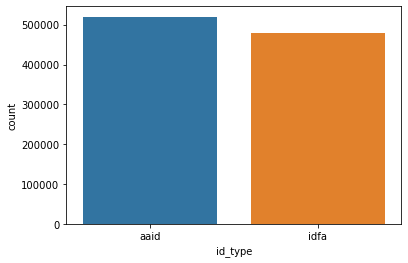

In [19]:
query = spark.sql(""" SELECT id_type, 
                             COUNT(*) as count, 
                             ROUND(COUNT(*)/1000000, 2) as percentage 
                       FROM movement 
                       GROUP BY id_type""")
sns.barplot(x = 'id_type', y = 'count', data = query.toPandas())
query.toPandas()

Next, 

,ad_id,count,percentage
0,11e5a770-0f34-415e-83cf-a3af24020e77,7476,0.01
1,068edb27-f26a-45c0-ade9-6f773a8c0789,5332,0.01
2,03463df8-2e41-4fd2-af6b-d999534f6b5f,3778,0.00
3,0d830d08-fbc5-4b77-ad71-12ac09899559,2950,0.00
4,08a38efb-cc48-42c5-b348-58d47841196e,2813,0.00


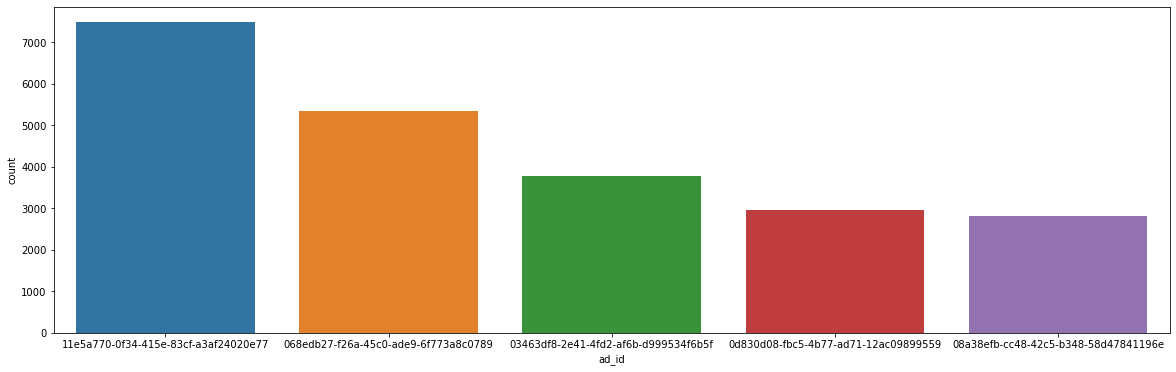

In [20]:
query = spark.sql(""" SELECT ad_id, 
                             COUNT(*) as count, 
                             ROUND(COUNT(*)/1000000, 2) as percentage 
                       FROM movement 
                       GROUP BY ad_id
                       ORDER BY count DESC
                       LIMIT 5""")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 6))
sns.barplot(x = 'ad_id', y = 'count', data = query.toPandas(), ax = ax)
query.toPandas()

### 3.1.1. Luoc do di chuyen tong quat

In [21]:
query = spark.sql("""SELECT ROUND(latitude, 2) AS x,
                            ROUND(longitude, 2) AS y,
                            ad_id,
                            id_type
                     FROM movement                     
                  """)
df_gen_trend = query.toPandas()
df_gen_trend.head(10)

,x,y,ad_id,id_type
0,35.47,-97.52,0001614a-2664-4297-905a-bb79851f4576,aaid
1,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
2,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
3,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
4,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
5,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
6,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
7,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
8,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid
9,61.15,-149.98,0001c560-b875-4b9b-b128-745a53a6be43,aaid


### Scatter-plot

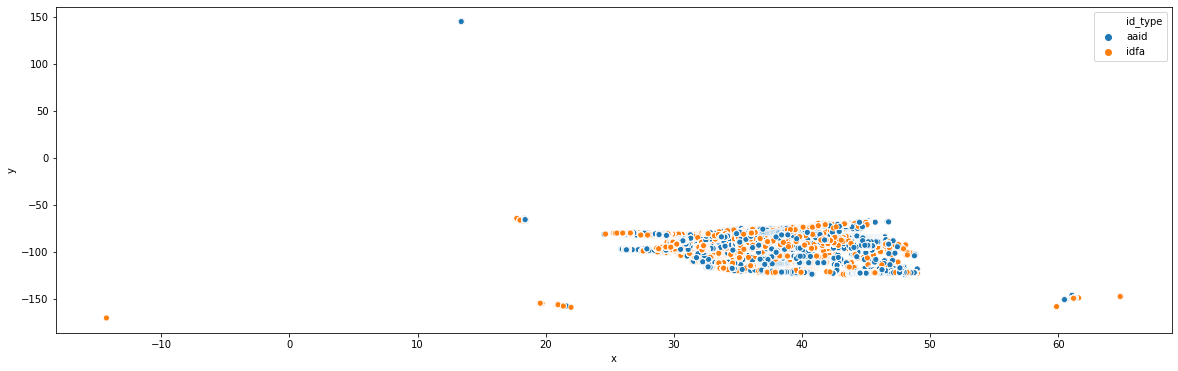

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 6))
sns.scatterplot(x = 'x', y = 'y', hue = 'id_type', data = df_gen_trend, ax = ax)

## 3.2 Segmentation.
### 3.2.1. Model 1. Only considering `x` and `y`

In [41]:
X = df_gen_trend[['x', 'y']]
X.shape

(1000000, 2)

### Find the `number of cluster`
Noting that, The `k-means algorithm` divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the `cluster “centroids”`; note that they are not, in general, points from $X$, although they live in the same space.
 
Hence, the `K-means algorithm` aims to choose centroids that minimise the **inertia**, or within-cluster **sum-of-squares criterion**:

$$ \sum_{x \in \mathcal{X}} \Vert x - x_{\text{pred}} \Vert^2  $$

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

- Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as `Principal component analysis (PCA)` prior to k-means clustering can alleviate this problem and speed up the computations.

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X )

Now, let apply the `KMeans algorithm`

Text(0, 0.5, 'inertia(K)')

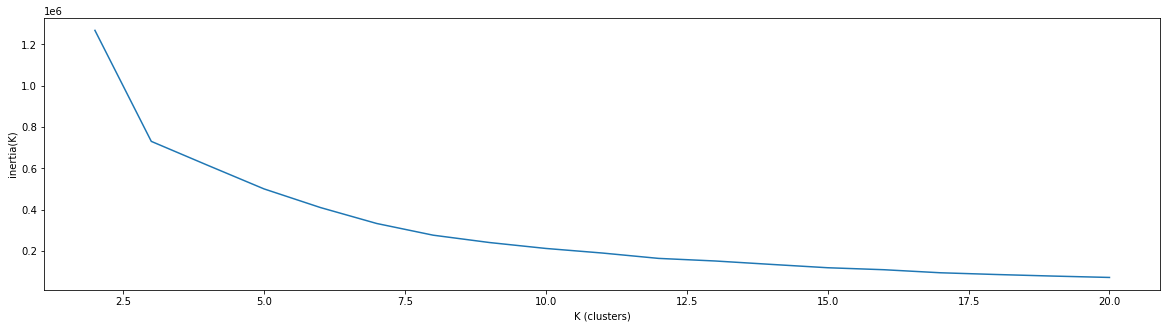

In [59]:
from sklearn.cluster import KMeans
t0 = time.time()
inertia_list = []
for n_clus in range(2, 21):
    kmeans = KMeans(n_clusters = n_clus, random_state = 0, max_iter = 1000).fit(X_scaled)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize = (20, 5))    
plt.plot(range(2, 21), inertia_list)
plt.xlabel('K (clusters)')
plt.ylabel('inertia(K)')
plt.show()
time.time() - t0

#### Grid-search CV

In [74]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV

params = {'n_clusters': list(range(2, 21))}
kmean = KMeans()
grid_km = GridSearchCV(param_grid=params, estimator = kmean, cv = 3)
grid_km.fit(X_scaled)

GridSearchCV(cv=3, estimator=KMeans(),
             param_grid={'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14, 15, 16, 17, 18, 19, 20]})

In [75]:
grid_km.best_params_

{'n_clusters': 20}

Assume that we choose the `K = 4`

In [67]:
kmeans = KMeans(n_clusters = 4, random_state=0).fit(X_scaled)
x = X_scaled[:, 0]
y = X_scaled[:, 1]
data = pd.DataFrame({'x_scale': x, 'y_scale': y, 'cluster': kmeans.labels_})

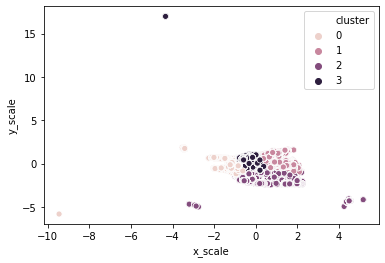

In [68]:
sns.scatterplot(x = 'x_scale', y = 'y_scale', hue = 'cluster', data = data)

In [69]:
data.groupby('cluster').count()

,x_scale,y_scale
cluster,,
0,241759,241759
1,354103,354103
2,146737,146737
3,257401,257401


### 3.2. Model 2. Including `id_type`

In [100]:
query = spark.sql("""SELECT ROUND(latitude, 2) AS x,
                            ROUND(longitude, 2) AS y,
                            id_type
                     FROM movement                     
                  """)
df_gen_trend = query.toPandas()
df_gen_trend.head(5)

,x,y,id_type
0,35.47,-97.52,aaid
1,61.15,-149.98,aaid
2,61.15,-149.98,aaid
3,61.15,-149.98,aaid
4,61.15,-149.98,aaid


In [101]:
df_id_type = pd.get_dummies(df_gen_trend['id_type'])

df_id_type.head()

,aaid,idfa
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [102]:
df_full = pd.concat([data[['x_scale', 'y_scale']], df_id_type], axis = 1)
df_full.head()

,x_scale,y_scale,aaid,idfa
0,-0.260049,-0.524657,1,0
1,4.487064,-4.320563,1,0
2,4.487064,-4.320563,1,0
3,4.487064,-4.320563,1,0
4,4.487064,-4.320563,1,0


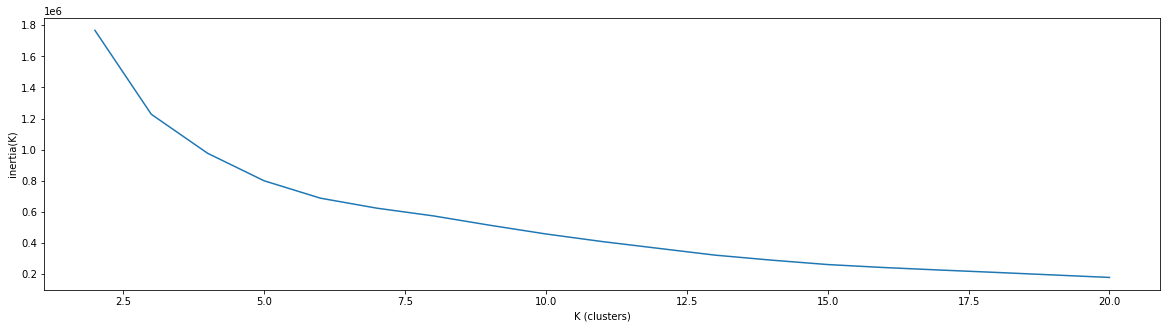

203.51300048828125

In [103]:
t0 = time.time()
inertia_list = []
for n_clus in range(2, 21):
    kmeans = KMeans(n_clusters = n_clus, random_state = 0, max_iter = 1000).fit(df_full)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize = (20, 5))    
plt.plot(range(2, 21), inertia_list)
plt.xlabel('K (clusters)')
plt.ylabel('inertia(K)')
plt.show()
time.time() - t0